<a href="https://colab.research.google.com/github/compartia/nlp_tools/blob/master/Search_patterns_right_in_TF_(solo_session).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
GLOBALS__={}

## MAIN, init, load code

In [0]:
#@title  { form-width: "300px", display-mode: "form" }
import os






# ''' AZ:-IMPORT CODE GITHUB----------------------------------------------😺------ '''
import sys
# ====================================
# ====================================
_git_branch = "in-tensors"  # @param {type:"string"}
# ====================================
# ====================================


def _init_import_code_from_gh():
  if 'GLOBALS__' not in globals():
    print('adding global GLOBALS__')
    global GLOBALS__
    GLOBALS__ = {}

  if '_init_import_code_from_gh' in GLOBALS__:
    print('👌 code already imported from GitHub!')
    return

  import subprocess
  def exec(x):
    r = subprocess.check_output(x, shell=True)
    r = r.decode('unicode-escape').encode('latin1').decode('utf8')
    print(r)

  print(f"fetching code from GitHub.....{_git_branch}")
  try:
    exec('rm -r nlp_tools')
  except:
    pass
  exec(f'git clone --single-branch --branch {_git_branch} https://github.com/compartia/nlp_tools.git nlp_tools')

  print('🦊 GIT revision:')
  exec('cd nlp_tools\ngit rev-list --reverse HEAD | awk "{ print NR }" | tail -n 1\ngit branch\ngit log -3 --pretty=%B')

  sys.path.insert(0, 'nlp_tools')

  # self-test
  from text_tools import untokenize
  print(untokenize(['code', 'imported', 'OK 👍']))

  print('installing antiword...')
  exec('sudo apt-get install antiword')

  print('installing docx2txt...')
  exec("pip install docx2txt")

  GLOBALS__['_init_import_code_from_gh'] = True

  ''' AZ:-------------------------------------------------IMPORT CODE GITHUB-😺---'''
  print('❤️ DONE importing Code fro GitHub')


# AZ:-INIT ELMO-----------------------------------------------------------------------------------

import tensorflow_hub as hub

#
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML


 

# AZ:- THE CODE----------------------------------------------------------------------------------

def _init_the_code(reset=False):
  if '_init_the_code' in GLOBALS__ and not reset:
    print('👌 Code is alredy imported!')
    return

  from renderer import HtmlRenderer
  from renderer import to_multicolor_text
  from renderer import known_subjects_dict

  from structures import ContractSubject
  from contract_parser import ContractDocument3

  from ml_tools import ProbableValue

  from legal_docs import LegalDocument
  from renderer import as_warning, as_headline_3, as_offset, as_smaller

  class DemoRenderer(HtmlRenderer):

    def render_color_text(self, tokens, weights, colormap='coolwarm', print_debug=False, _range=None):
      html = self.to_color_text(tokens, weights, colormap, print_debug, _range)
      display(HTML(html))

    def to_color_text(self, tokens, weights, colormap='coolwarm', print_debug=False, _range=None):
      return super()._to_color_text(tokens, weights, mpl, colormap=colormap, _range=_range)

    def render_multicolor_text(self, tokens, vectors, colormap, min_color=None, _slice=None):
      display(HTML(to_multicolor_text(tokens, vectors, colormap, min_color=min_color, _slice=_slice)))

     
     

     
  GLOBALS__['renderer'] = DemoRenderer()

  # AZ:----------PROTOCOLS RENDERER-------------------------

   

 

  GLOBALS__['_init_the_code'] = True
  print("❤️ DONE initializing the code")

  # AZ:-------------------------------------------------Init Protocols context===



def interactive_upload(filetype):
  from google.colab import files
  import docx2txt

  print(f'Please select "{filetype}" .docx file:')
  uploaded = files.upload()
  docs = []
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

    with open(fn, "wb") as df:
      df.write(uploaded[fn])
      df.close()

    # extract text

    text = ''
    try:
      text = docx2txt.process(fn)
    except:
      print("Unexpected error:", sys.exc_info())
      os.system('antiword -w 0 "' + fn + '" > "' + fn + '.txt"')
      with open(fn + '.txt') as f:
        text = f.read()
    print("Символов в оригинальном документе:", len(text))
    docs.append(text)
    return docs

  
# AZ:- ENDO OF THE THE CODE------------------------------------------------XXXXX
# AZ:- ENDO OF THE THE CODE------------------------------------------------XXXX

"""# step 0. Инит"""

## do preparation here

# 1.
_init_import_code_from_gh()
 
# 3.
_init_the_code(True)



# A model 💎 for finding closest embedding to a pattern
1. At first stage, we calculate attention vectors (AV) for every pattern
2. Then, for each AV we're finding the closest point (`best point`) in text embedding space, 
3. Then we're calculating "improved" vectors -- we calculate distance from the `"best point"` (actually, from the best *window*)  to each point in text embedding space.  
  
WARNING: this should be used only if `best point` is close enough to the pattern

#  Finalize TF graph for embedding 💎

In [3]:
from typing import List

import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
# returs
from text_tools import Tokens


def _embedd(elmo, text_input_p, lengths_p):
  # 1. text embedding
  return elmo(
    inputs={
      "tokens": text_input_p,
      "sequence_len": lengths_p
    },
    signature="tokens",
    as_dict=True)["elmo"]


def _normalizie(x):
  #       _norm = tf.norm(x, keep_dims=True)
  #       return x/ (_norm + 1e-8)
  return tf.nn.l2_normalize(x, 0)  # TODO: try different norm


def get_vector_similarity(a, b):
  a_norm = _normalizie(a)  # normalizing is kinda required if we want cosine return [0..1] range
  b_norm = _normalizie(b)  # DO WE? TODO: try different norm
  return 1.0 - tf.losses.cosine_distance(a_norm, b_norm, axis=0)  ##TODO: how on Earth Cosine could be > 1????


def _center(emb):
  # todo reduce sum or reduce mean? Does not matter because we normalize it
  return tf.reduce_sum(emb, axis=0)


def get_matrix_similarity(a, b):
  # calc mean embedding vector for the window in the words embeddings
  a_center = _center(a)
  b_center = _center(b)
  return get_vector_similarity(a_center, b_center)


def _convolve(text_range, _text_embedding, pattern_emb_sliced ):
  window_size = tf.shape(pattern_emb_sliced)[0]
  return tf.map_fn(lambda i: get_matrix_similarity(_text_embedding[i:i + window_size], pattern_emb_sliced),
                   text_range, dtype=tf.float32)


def for_every_pattern(pattern_info, _text_embedding, text_range):
  pattern_len = pattern_info[0]
  pattern_slice = pattern_info[1]
  _pattern_slice = slice(pattern_slice[0], pattern_slice[1] )
  pattern_emb_sliced = pattern_info[2][_pattern_slice]

  
  return _convolve(text_range, _text_embedding, pattern_emb_sliced)



def build_graph():
  # BUILD IT --------------------------------------------
  elmo = hub.Module('https://storage.googleapis.com/az-nlp/elmo_ru-news_wmt11-16_1.5M_steps.tar.gz', trainable=False)
 
  text_input = tf.placeholder(dtype=tf.string )
  text_lengths = tf.placeholder(dtype=tf.int32 )



  number_of_patterns_old = tf.placeholder(dtype=tf.int32, name='number_of_patterns', shape=[])
  pattern_input = tf.placeholder(dtype=tf.string, name='pattern_input' )  
  pattern_lengths = tf.placeholder(dtype=tf.int32, name='pattern_lengths' )
  pattern_slices = tf.placeholder(dtype=tf.int32, name='pattern_slices', shape=[None, 2])
  patterns_max_len = tf.placeholder(dtype=tf.int32, name='patterns_max_len', shape=[])
  
  patterns_max_len_new = tf.math.reduce_max(pattern_lengths, keepdims=True)
 
  number_of_patterns = tf.shape(pattern_input)[0]
    
  _nl = tf.constant(['\n'])
   
  _padding = tf.tile(_nl,  patterns_max_len_new )

  text_input_ext =[ tf.concat( [text_input[0], _padding] , axis=0) ]
  
  # 1. text embedding---------------
  _text_embedding = _embedd(elmo, text_input_ext, [text_lengths[0] + patterns_max_len_new[0]] )[0]  # TODO: try to deal with chunked text
  # 2. patterns embedding
  _patterns_embeddings = _embedd(elmo, pattern_input, pattern_lengths)

 
  text_range = tf.range(text_lengths[0], dtype=tf.int32 )
  patterns_range = tf.range(number_of_patterns, dtype=tf.int32)

  
  cosine_similarities = tf.map_fn(lambda i: for_every_pattern( (pattern_lengths[i], pattern_slices[i],_patterns_embeddings[i]), _text_embedding, text_range), patterns_range, dtype=tf.float32)
    
  def improve_dist(attention_vector, pattern_len):
    """
      finding closest point (aka 'best point')
    """
    max_i = tf.math.argmax(attention_vector, output_type=tf.dtypes.int32)
    best_embedding_range = _text_embedding[max_i:max_i + pattern_len]    
    return _convolve(text_range, _text_embedding, best_embedding_range)
   
  def find_best_embeddings():
    return tf.map_fn(lambda i: improve_dist(cosine_similarities[i], pattern_lengths[i]), patterns_range, dtype=tf.float32 )

  
  cosine_similarities_improved = find_best_embeddings()
  
  
  return [cosine_similarities, cosine_similarities_improved], \
         [text_input, text_lengths ], \
         [number_of_patterns_old, pattern_input, pattern_lengths, pattern_slices, patterns_max_len]



def make_embedding_session_and_graph():
  embedding_graph = tf.Graph()

  with embedding_graph.as_default():
    inout = build_graph()

    init_op = tf.group([tf.global_variables_initializer(), tf.tables_initializer()])

    embedding_session = tf.Session(graph=embedding_graph)
    embedding_session.run(init_op)
    
  embedding_graph.finalize()

  
  return inout, embedding_session

inout, embedding_session = make_embedding_session_and_graph()

W0429 15:51:06.426384 140178143278976 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
W0429 15:51:09.435341 140178143278976 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/losses/losses_impl.py:331: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


In [0]:
from text_tools import tokenize_text
def prepare_patters_for_embedding(patterns):

  tokenized_sentences_list = []
  regions = []

  
  maxlen = 0
  lens = []
  for p in patterns:
    ctx_prefix, pattern, ctx_postfix = p.prefix_pattern_suffix_tuple
    
    sentence = ' '.join((ctx_prefix, pattern, ctx_postfix))

    prefix_tokens = tokenize_text(ctx_prefix)
    pattern_tokens = tokenize_text(pattern)
    suffix_tokens = tokenize_text(ctx_postfix)

    start = len(prefix_tokens)
    end = start + len(pattern_tokens)

    sentence_tokens = prefix_tokens + pattern_tokens + suffix_tokens

    # print('embedd_contextualized_patterns', (sentence, start, end))

    regions.append( [start, end] ) 
    tokenized_sentences_list.append(sentence_tokens)
    lens.append(len(sentence_tokens))
    if len(pattern_tokens) > maxlen:
      maxlen = len(sentence_tokens)


  _strings = []

  for s in tokenized_sentences_list:
    s.extend(['\n'] * (maxlen - len(s)))
    _strings.append(s)
    # print(s)
  _strings = np.array(_strings)
  
  return _strings, lens, regions, maxlen



### Make patterns

In [40]:
from patterns import AbstractPatternFactory, FuzzyPattern


ORG_TYPES = {
  'org_unknown': 'undefined',
  'org_ao':   'Акционерное общество',
  'org_zao':  'Закрытое акционерное общество',
  'org_oao':  'Открытое акционерное общество',
  'org_ooo':  'Общество с ограниченной ответственностью',
  'org_nc':   'Некоммерческая организация',
  'org_fpsi': 'Фонд поддержки социальных инициатив',
  'org_any_1': 'Учреждение',
  'org_any_2': 'Организация'
    
}




class PF(AbstractPatternFactory):
  def __init__(self):
    AbstractPatternFactory.__init__(self, None)
    self._build_ner_patterns()

  def _build_ner_patterns(self):
    def cp(name, tuples):
      return self.create_pattern(name, tuples)

    for o_type in ORG_TYPES.keys():
      if o_type != 'org_unknown':
        cp(o_type, ('', ORG_TYPES[o_type], ' «'))

    
    cp('_named_1', ( ', ', 'именуемое в дальнейшем', ''))
    cp('_made_a_deal', ( '', 'заключили', 'настоящий договор о нижеследующем'))
    
    cp('_acting_on', ( '', 'действующего на основании', ''))
    
    cp('_deal_side_1', ( '', 'с одной стороны', ''))
    cp('_deal_side_2', ( '', 'с другой стороны', ''))
    

    cp('_in_face', ( '', 'в лице', ''))
     
    
 
     

# ---
pf = PF()


#TEST-------------
 
prepare_patters_for_embedding(pf.patterns)

(array([['Акционерное', 'общество', '«', '\n', '\n'],
        ['Закрытое', 'акционерное', 'общество', '«', '\n'],
        ['Открытое', 'акционерное', 'общество', '«', '\n'],
        ['Общество', 'с', 'ограниченной', 'ответственностью', '«'],
        ['Некоммерческая', 'организация', '«', '\n', '\n'],
        ['Фонд', 'поддержки', 'социальных', 'инициатив', '«'],
        ['Учреждение', '«', '\n', '\n', '\n'],
        ['Организация', '«', '\n', '\n', '\n'],
        [',', 'именуемое', 'в', 'дальнейшем', '\n'],
        ['заключили', 'настоящий', 'договор', 'о', 'нижеследующем'],
        ['действующего', 'на', 'основании', '\n', '\n'],
        ['с', 'одной', 'стороны', '\n', '\n'],
        ['с', 'другой', 'стороны', '\n', '\n'],
        ['в', 'лице', '\n', '\n', '\n']], dtype='<U16'),
 [3, 4, 4, 5, 3, 5, 2, 2, 4, 5, 3, 3, 3, 2],
 [[0, 2],
  [0, 3],
  [0, 3],
  [0, 4],
  [0, 2],
  [0, 4],
  [0, 1],
  [0, 1],
  [1, 4],
  [0, 1],
  [0, 3],
  [0, 3],
  [0, 3],
  [0, 2]],
 5)

### Sample text

In [17]:

from text_tools import tokenize_text
import re
from text_normalize import normalize_text, replacements_regex
uploaded = """
Берлинская дада-ярмарка и Международная выставка сюрреализма в париж­ской галерее «Изящные искусства» в 1938 году стали высшими точками развития двух движений и подвели им итог. На «Сюрреалис­тической улице», за манекенами, выстроившимися в проходе в главный зал, располагались плакаты, приглашения, объявления и фотографии, отсылающие к ранним этапам сюрреализма. В главном зале, за оформление которого отвечал Марсель Дюшан 
 
, а за освеще­ние — Ман Рэй 
 
, картины 1920-х годов висели рядом с более ранними работами, что подчеркивало развити
е сюрреалистического «интернаци­она­ла». Зародившись как литературное течение, к концу 1930-х годов сюрреализм уже около 15 лет господствовал в художественном авангарде Парижа. Прежде чем пойти на спад с началом
Второй мировой войны, он стал частью светской культуры Парижа и даже до некотоРой
степени присягнул высокой моде, подобно тому как русский авангард — пусть совсем иначе — присягну 
в свое время революции. Изящество стиля, свойственное сюррелизму, способствоало этому 

­ сближению, которое, в свою очередь, упрочило положение многих представителей направления в обществе. 

Однако поначалу для литераторов и художников-бунтарей, ничуть не стремившихся к социаль­ному успеху, 
была куда более естественной связь с дадаизмом"""

#UNCOMMENT TO UPLOAD============================================================
uploaded = interactive_upload('Protocol')[0]
# 
_regex_addon = [
    (re.compile(r'[­]'), '-'),
]
TOKENS=tokenize_text( normalize_text(uploaded, replacements_regex+_regex_addon))
# TOKENS

Please select "Protocol" .docx file:


Saving ЕЮ Договор Купля-продажа.doc to ЕЮ Договор Купля-продажа (1).doc
User uploaded file "ЕЮ Договор Купля-продажа.doc" with length 66048 bytes
Unexpected error: (<class 'KeyError'>, KeyError("There is no item named 'word/document.xml' in the archive",), <traceback object at 0x7f7d21ca3d88>)
Символов в оригинальном документе: 5984


##  `find_patterns` (Main)

In [47]:
from fuzzy_matcher import AttentionVectors, FuzzyMatcher

def find_patterns(embedding_session, in_out, text_tokens:Tokens, patterns:List[FuzzyPattern]) -> AttentionVectors:
  
  patterns_tokens, patterns_lengths, pattern_slices, patterns_max_len = prepare_patters_for_embedding(patterns)
  
  runs=in_out[0]
  feeds_t = in_out[1]
  feeds_p = in_out[2]
  attentions, improved_attentions = embedding_session.run(in_out[0], feed_dict={\
      feeds_t[0]:[text_tokens], #text_input
      feeds_t[1]:[len(text_tokens)], #text_lengths
      
      feeds_p[0]:len(patterns),
      feeds_p[1]:patterns_tokens,
      feeds_p[2]:patterns_lengths,
      feeds_p[3]:pattern_slices,
      feeds_p[4]:patterns_max_len
      
  })

  av = AttentionVectors()

  for i in range(len(pf.patterns)):
    pattern = pf.patterns[i]
    av.add(pattern.name,   attentions[i], improved_attentions[i])

  return av


# test simple
  
av = find_patterns(embedding_session, inout, text_tokens=[',', 'именуемое', 'в', 'дальнейшем'], patterns=pf.patterns)
print(av.vectors)

{'org_ao': array([0.21266556, 0.17896402, 0.16885698, 0.21746135], dtype=float32), 'org_zao': array([0.23325098, 0.250538  , 0.24615002, 0.25678843], dtype=float32), 'org_oao': array([0.21547449, 0.22771418, 0.22051537, 0.2307924 ], dtype=float32), 'org_ooo': array([0.26180136, 0.26138628, 0.23302579, 0.21275109], dtype=float32), 'org_nc': array([0.14126611, 0.16003704, 0.13963175, 0.195369  ], dtype=float32), 'org_fpsi': array([0.17678106, 0.18190384, 0.18675935, 0.17413795], dtype=float32), 'org_any_1': array([0.19499505, 0.1622957 , 0.1471892 , 0.16816616], dtype=float32), 'org_any_2': array([0.10875154, 0.10856128, 0.13075495, 0.07560194], dtype=float32), '_named_1': array([0.7637643 , 0.8924363 , 0.697175  , 0.48327625], dtype=float32), '_made_a_deal': array([0.13879097, 0.08992666, 0.11715615, 0.0893538 ], dtype=float32), '_acting_on': array([0.27485454, 0.2884084 , 0.19172174, 0.09715939], dtype=float32), '_deal_side_1': array([0.21572453, 0.21237075, 0.18566024, 0.15405083], dt

In [48]:
%%time
 
av = find_patterns(embedding_session, inout, text_tokens=TOKENS, patterns=pf.patterns)


from text_tools import hot_quotes
_quotes_open, _quotes_closing = hot_quotes(TOKENS)

av.add('_quotes_open', _quotes_open, _quotes_open)
av.add('_quotes_closing', _quotes_closing, _quotes_closing)


CPU times: user 18 s, sys: 2.68 s, total: 20.7 s
Wall time: 11.8 s


#### render results

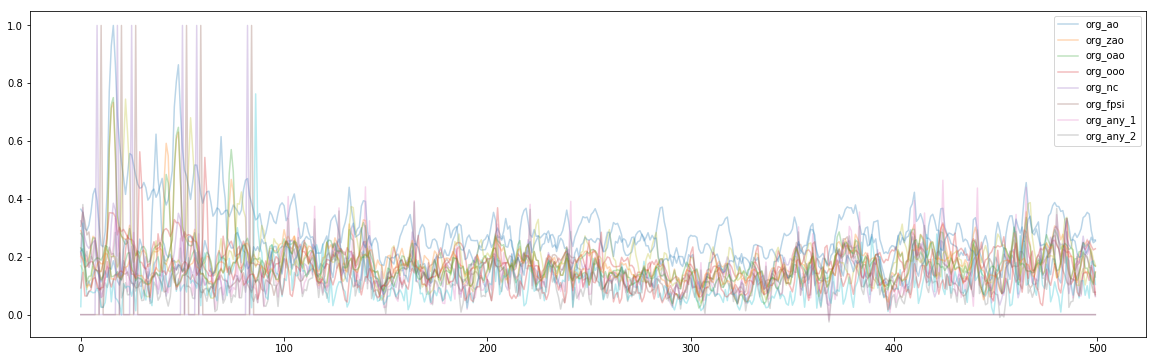

In [49]:
_slice=slice(0,500)
fig = plt.figure(figsize=(20, 6))
ax = plt.axes()
for name in av.vectors:
  ax.plot(av.get_best(name, relu_th=0.8)[_slice], label=name, alpha=0.3)
plt.legend(loc='upper right')

#Fuzzy matcher

In [0]:
%%time
import numpy as np

from ml_tools import momentum_t, max_exclusive_pattern, relu
from fuzzy_matcher import AttentionVectors, FuzzyMatcher
 
_slice=slice(0,400)





fm = FuzzyMatcher(av)


fm.after('org_*', 15) \
  .after('_deal_side_1', 30) \
  .before('_named_*', 40) \
  .before('_acting_on', 40) \
  .before('_deal_side_*', 100)\
  .before('_made_a_deal', 200) \
  .after('_quotes_open', 6)\
  .before('_quotes_closing', 6)\
  .before('_in_face', 10)


vvv = fm.compile()
# vvv = relu(vvv, vvv.max() * 0.81)

fig = plt.figure(figsize=(20, 6))
ax = plt.axes()
ax.plot(vvv[_slice])


GLOBALS__['renderer'].render_color_text(TOKENS, vvv)